# Building a Recommendation System Using CNN
![](https://www.researchgate.net/profile/Andreas_Veit/publication/282181243/figure/fig1/AS:360995122892808@1463079352720/Visualization-of-a-2D-embedding-of-the-style-space-trained-with-strategic-sampling.png)



## Introduction

In this notebook, I will use ResNet50 Model and Convolutional Autoencoder Model to create two kind of Fashion Embeddings. We will use embeddings to identify similar items, this information will be used to recommend similar content in Recommendation System.


* **Data Preparation**
* **Use ResNet50 Model to Recommendation**
* **Use Convolutional Autoencoder Model to Recommendation**
* **Visualization Latent Space of Contents**

#### Configure VM

In [ ]:
!pip install swifter

In [ ]:
!pip install tensorflow

We can use the Embedding as input of the model, containing a reduced dimensionality but with much semantic information.

## Data Preparation
To begin this exploratory analysis, first use `matplotlib` to import libraries and define functions for plotting the data.

In [ ]:
#Mount with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -u "/content/drive/MyDrive/test/data/archive.zip" -d "/content/drive/MyDrive/test/data/fashion4"

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/drive/MyDrive/test/data/fashion4/myntradataset/images/5813.jpg  
  inflating: /content/drive/MyDrive/test/data/fashion4/myntradataset/images/58131.jpg  
  inflating: /content/drive/MyDrive/test/data/fashion4/myntradataset/images/58132.jpg  
  inflating: /content/drive/MyDrive/test/data/fashion4/myntradataset/images/58133.jpg  
  inflating: /content/drive/MyDrive/test/data/fashion4/myntradataset/images/58135.jpg  
  inflating: /content/drive/MyDrive/test/data/fashion4/myntradataset/images/58136.jpg  
  inflating: /content/drive/MyDrive/test/data/fashion4/myntradataset/images/58137.jpg  
  inflating: /content/drive/MyDrive/test/data/fashion4/myntradataset/images/58138.jpg  
  inflating: /content/drive/MyDrive/test/data/fashion4/myntradataset/images/58139.jpg  
  inflating: /content/drive/MyDrive/test/data/fashion4/myntradataset/images/5814.jpg  
  inflating: /content/drive/MyDrive/test/data/fashion4/myntradataset/images/58140.jpg  
  infla

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/test/data/fashion4/" # specify folder path
print(os.listdir(DATASET_PATH)) # show file names in folder

['images', 'myntradataset', 'styles.csv']


In [ ]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000, error_bad_lines=False) # read the csv file from the specified path as a dataframe
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1) # add a new column based on the id column and name it image
df = df.reset_index(drop=True) # rearrange index
df.head(10) # display the first ten rows of the dataframe

<ipython-input-103-7d725e7a88e7>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000, error_bad_lines=False) # read the csv file from the specified path as a dataframe


id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   
5   1855    Men        Apparel     Topwear      Tshirts       Grey  Summer   
6  30805    Men        Apparel     Topwear       Shirts      Green  Summer   
7  26960  Women        Apparel     Topwear       Shirts     Purple  Summer   
8  29114    Men    Accessories       Socks        Socks  Navy Blue  Summer   
9  30039    Men    Accessories     Watches      Watches      Black  Winter   

   year   usage                             productDisplayName      image  
0  2011  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012  Casual                          Puma Men Grey T-shirt  53759.jpg  
5  2011  Casual           Inkfruit Mens Chain Reaction T-shirt   1855.jpg  
6  2012  Ethnic               Fabindia Men Striped Green Shirt  30805.jpg  
7  2012  Casual                  Jealous 21 Women Purple Shirt  26960.jpg  
8  2012  Casual                       Puma Men Pack of 3 Socks  29114.jpg  
9  2016  Casual                         Skagen Men Black Watch  30039.jpg

In [ ]:
import cv2
def plot_figures(figures, nrows = 1, ncols = 1, figsize = (8, 8)):
    """Plot a dictionary of figures

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

def img_path(img):
    """Get image path

    Parameters
    ----------
    img : image name
    """

    return DATASET_PATH+"images/"+img

def load_image(img, resized_fac = 3):
    """Get image path

    Parameters
    ----------
    img : image name
    resized_fac ： the size fraction you want to resized
    """

    img = cv2.imread(img_path(img)) # read image
    if type(img) == np.ndarray:
      w, h, _ = img.shape # view image size
      resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_LINEAR) # adjust pixel values using linear interpolation
      return resized
    else:
      return img



In [ ]:
# search images that can not be read
result = df['image'].apply(load_image)
delt = [i for i in range(len(result)) if type(result[i]) != np.ndarray]
delt

[129, 340, 814, 1912, 2669, 3567, 3849, 4954]

In [ ]:
df = df.drop(delt)  # delete images that can not be read
df = df.reset_index(drop=True) # rearrange index

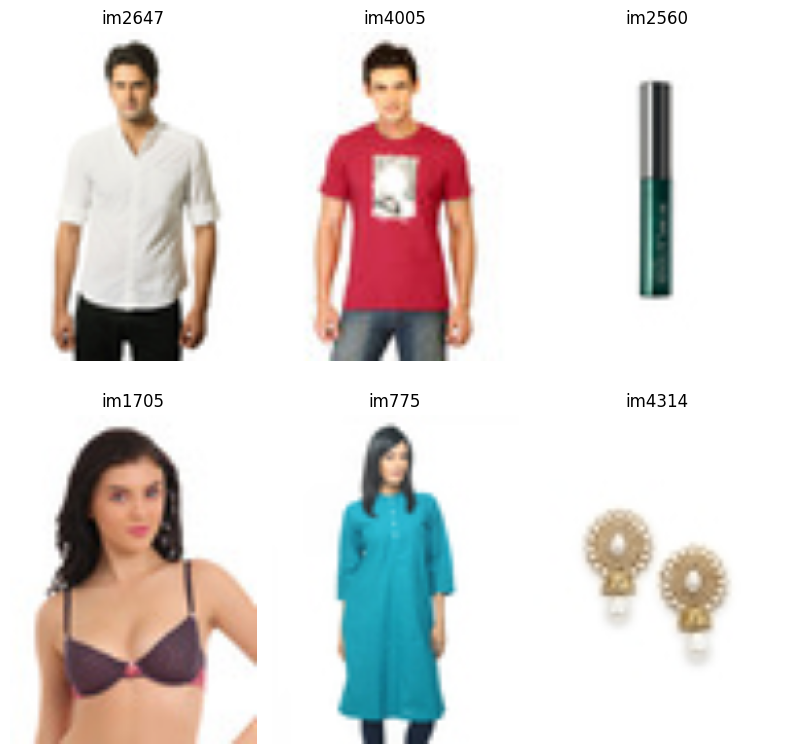

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

The Dataset is made up of different items that can be found in a marketplace. The idea is to use embeddings to search for similarity and find similar items just using the image.

<Axes: >

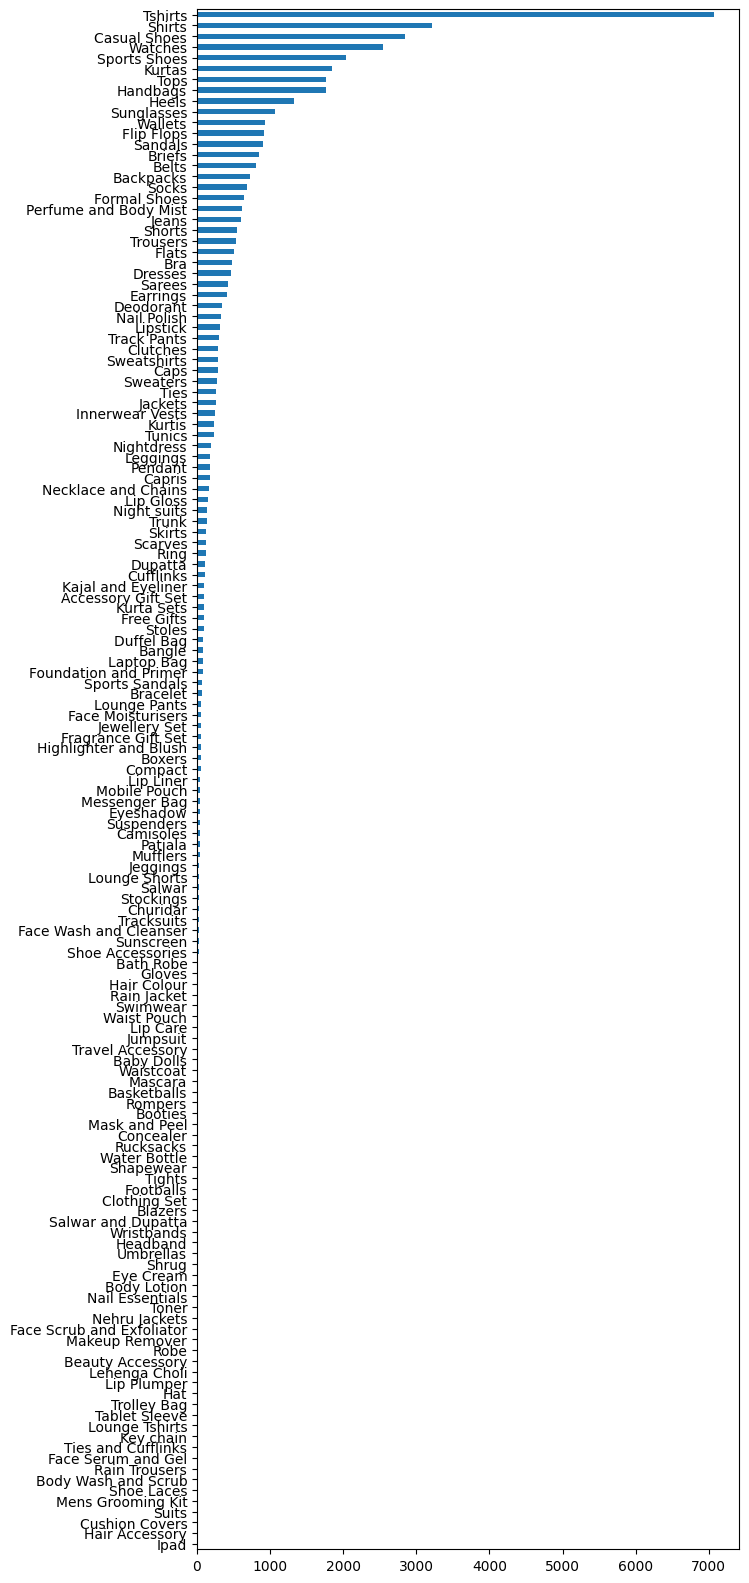

In [ ]:
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

## Use ResNet50 Model to Recommendation

In [ ]:
import tensorflow as tf
import keras
from keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
tf.__version__

'2.12.0'

In [ ]:
# Input Shape
img_width, img_height, _ = 224, 224, 3 # load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([base_model, GlobalMaxPooling2D()])

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
def get_embedding1(model, img_name):
    # reshape
    img = tf.keras.utils.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to array
    x = tf.keras.utils.img_to_array(img)
    # expand dim (1, w, h)
    x = np.expand_dims(x, axis=0)
    # pre process input
    x = preprocess_input(x)
    return model.predict(x).reshape(-1)

Get item Embedding

In [ ]:
emb = get_embedding1(model, df.iloc[0].image)
emb.shape

1/1 [==============================] - 0s 203ms/step


(2048,)

(240, 180, 3)
[ 2.4519024  6.7045918  0.        ...  2.1364102  2.6233673 18.563385 ]


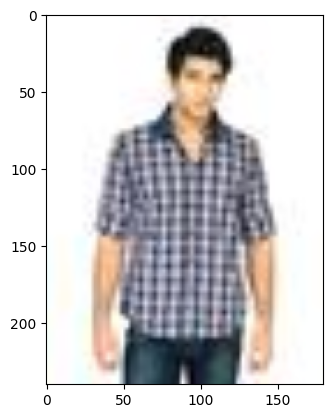

In [ ]:
img_array = load_image(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [ ]:
df.shape

(44424, 11)

Get Embedding for all itens in dataset

In [ ]:
%%time
# import swifter

# Parallel Apply
df_sample = df#.sample(10)
map_embeddings1 = df_sample['image'].apply(lambda img: get_embedding1(model, img))
df_embs1 = map_embeddings1.apply(pd.Series)

print(df_embs1.shape)
df_embs1.head()

1/1 [==============================] - 0s 181ms/step
(4984, 2048)
CPU times: user 30min 53s, sys: 33.4 s, total: 31min 26s
Wall time: 28min 22s


0          1         2          3         4         5          6     \
0  2.451902   6.704592  0.000000   1.978811  4.560525  3.994560   7.357246   
1  2.160769  13.004471  0.092261   6.950655  5.372182  0.000000  15.559413   
2  0.000000   2.099401  1.121339   5.048748  2.971097  4.301216   3.864701   
3  0.000000   5.336296  1.670128  11.411585  1.258607  0.000000  12.816566   
4  2.663737  15.295514  0.032797   2.476947  6.908787  2.586334   9.054920   

       7         8         9     ...       2038       2039      2040  \
0  8.840917  0.173762  0.545165  ...   1.739150   5.757437  2.347399   
1  2.178862  0.848540  0.146074  ...   2.459621   8.469252  5.472924   
2  1.902131  0.494964  4.596426  ...   0.000000  16.961672  2.302290   
3  7.772416  0.845030  2.947617  ...  29.042677   1.647542  0.176536   
4  7.316333  0.000000  0.000000  ...   2.014317   6.502693  3.596580   

        2041      2042      2043       2044      2045       2046       2047  
0  23.496437  1.089250  0.000000   9.565607  2.136410   2.623367  18.563385  
1   8.990248  3.187696  0.256653   7.267735  0.000000   6.571846  17.669712  
2   1.838044  0.741307  0.000000   2.888033  2.204795   5.722476   6.089290  
3   0.000000  6.040610  1.806873  10.376248  0.000000  16.299793  16.499527  
4  19.685740  6.044688  0.000000   8.757937  2.211986   4.258552  17.862123  

[5 rows x 2048 columns]

#### Compute Similarity Between Items

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule Distance Matrix
cosine_sim1 = 1 - pairwise_distances(df_embs1, metric='cosine')
cosine_sim1[:4, :4]

array([[0.9999996 , 0.6358943 , 0.49575078, 0.59519005],
       [0.6358943 , 1.        , 0.509784  , 0.73752296],
       [0.49575078, 0.509784  , 1.        , 0.47131705],
       [0.59519005, 0.73752296, 0.47131705, 0.9999995 ]], dtype=float32)

#### Recommender Similar Items

In [ ]:
indices = pd.Series(range(len(df)), index=df.index)
indices

# function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender1(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim1[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]

    return indices.iloc[idx_rec].index, idx_sim

get_recommender1(2993, df, top_n = 5)

(Int64Index([4602, 3748, 2570, 2463, 2783], dtype='int64'),
 [0.91147184, 0.90563947, 0.880928, 0.8745753, 0.86440766])

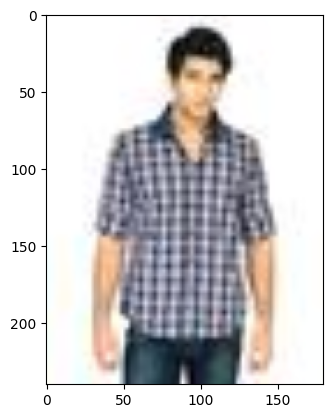

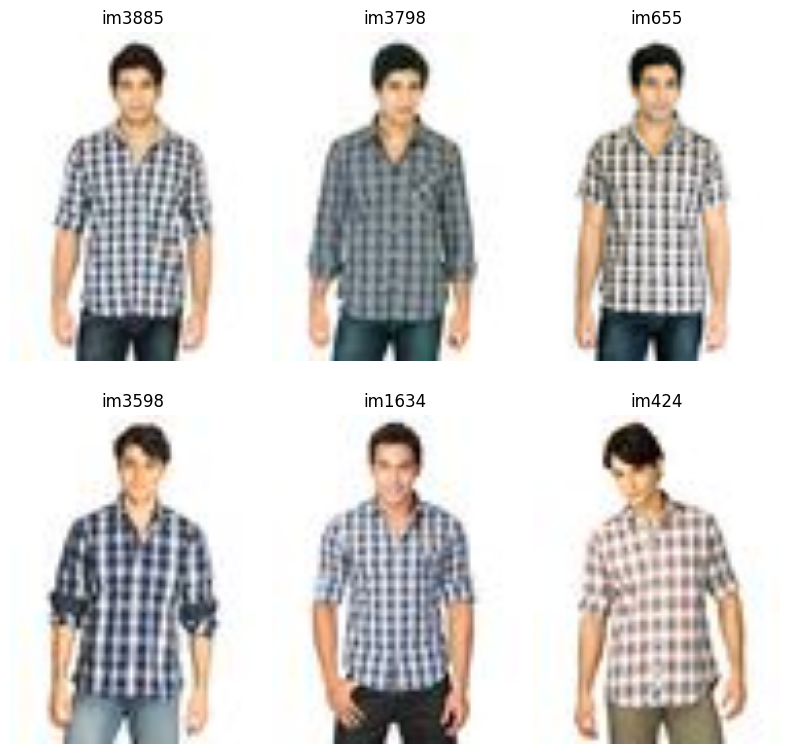

In [ ]:
idx_ref = 0

# Recommendations
idx_rec, idx_sim = get_recommender1(idx_ref, df, top_n = 6)

# Plot
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

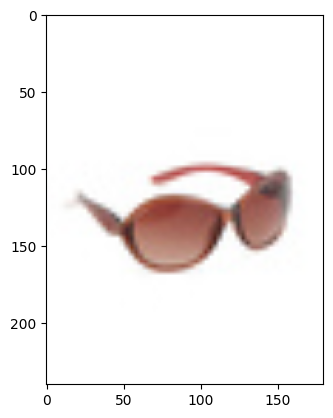

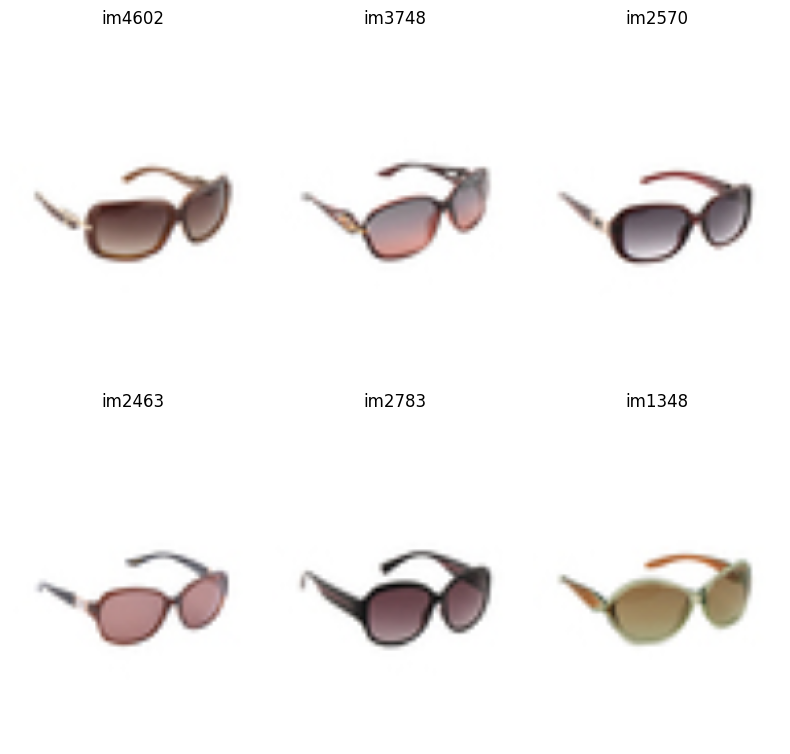

In [ ]:
# Idx Item to Recommender
idx_ref = 2993

# Recommendations
idx_rec, idx_sim = get_recommender1(idx_ref, df, top_n = 6)

# Plot
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

**Search for items similar to the reference to recommend. Apparently it's working!**

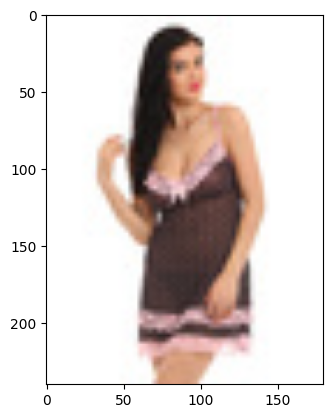

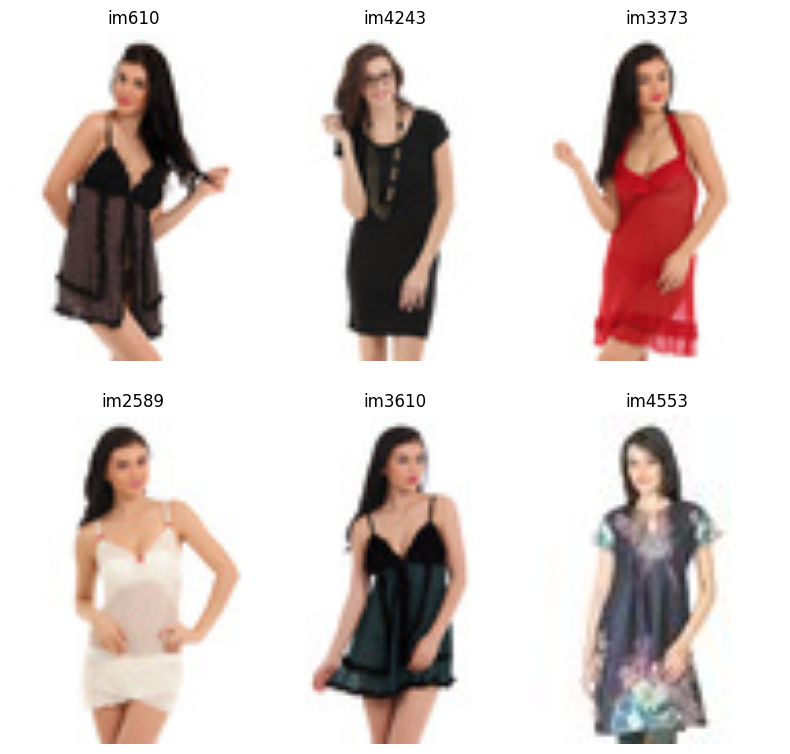

In [ ]:
idx_ref = 2989

# Recommendations
idx_rec, idx_sim = get_recommender1(idx_ref, df, top_n = 6)

# Plot
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

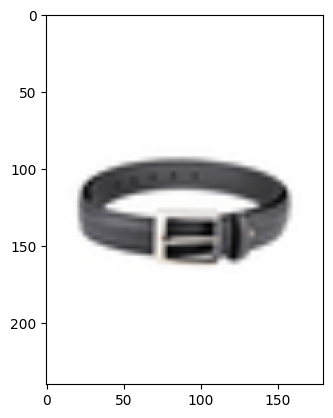

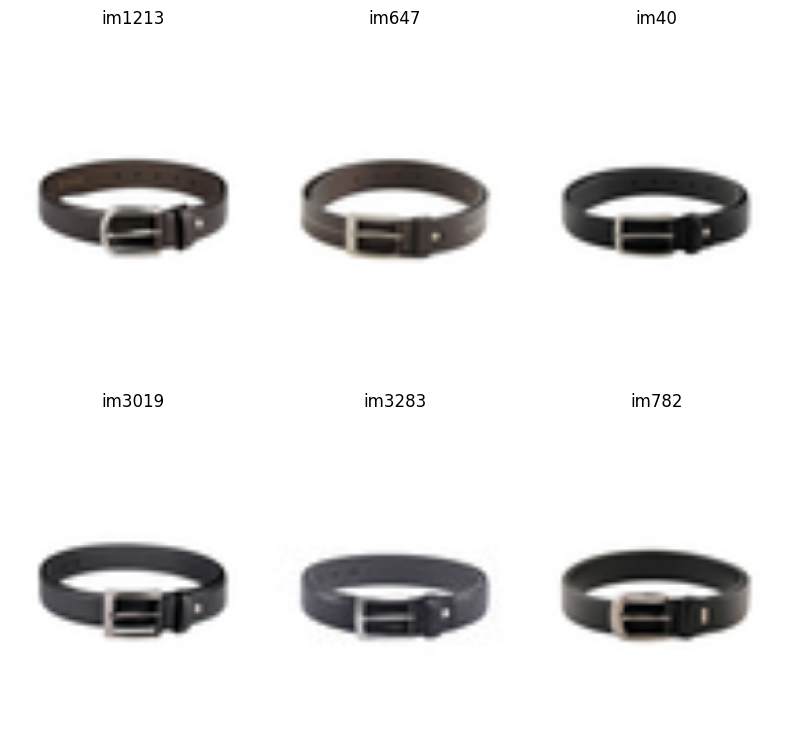

In [ ]:
idx_ref = 987

# Recommendations
idx_rec, idx_sim = get_recommender1(idx_ref, df, top_n = 6)

# Plot
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

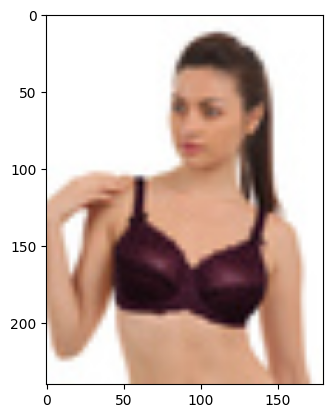

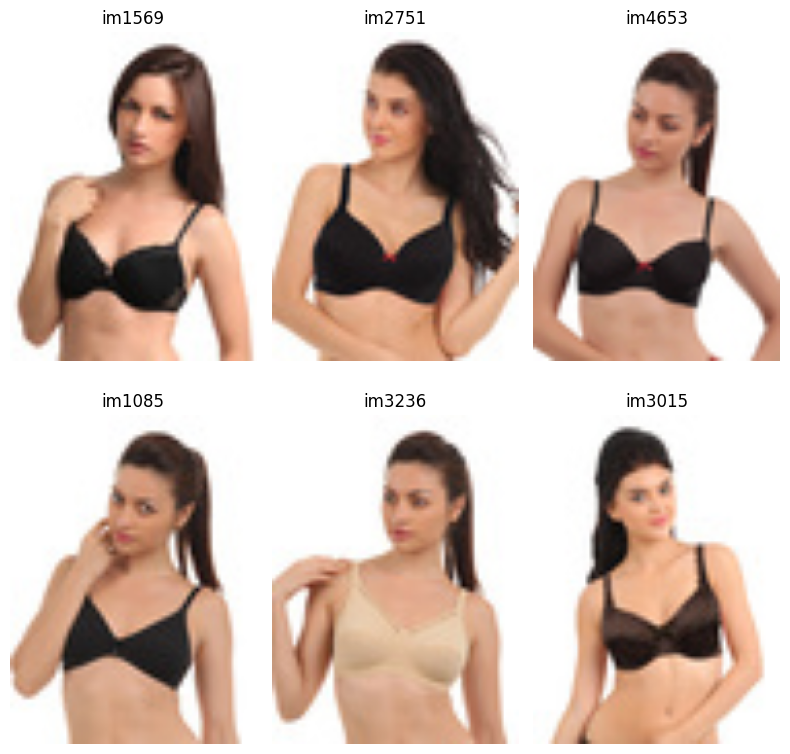

In [ ]:
idx_ref = 3524

# Recommendations
idx_rec, idx_sim = get_recommender1(idx_ref, df, top_n = 6)

# Plot
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

# Use Convolutional Autoencoder to Recommendation

In [ ]:
img = tf.keras.utils.load_img(img_path(df['image'].iloc[0]), target_size=(28, 28))
# img to array
x = tf.keras.utils.img_to_array(img)
# expand dim (1, w, h)
x = np.expand_dims(x, axis=0)
x.shape

(1, 28, 28, 3)

In [ ]:
def get_x(img_name):
    # reshape
    img = tf.keras.utils.load_img(img_path(img_name), target_size=(28, 28))
    # img to array
    x = tf.keras.utils.img_to_array(img)
    # expand dim (1, w, h)
    x = np.expand_dims(x, axis=0)
    # pre process input
    x = preprocess_input(x)
    x = x.astype('float32')/255.
    return x

In [ ]:
df_all = df
df_train = df.sample(frac=0.9, random_state=1234, axis=0)
df_val = df.drop(df_train.index).sample(frac=0.5, random_state=1234, axis=0)
df_test = df.drop(df_train.index).drop(df_val.index)

df_all = df_all['image'].apply(lambda img: get_x(img))
df_train = df_train['image'].apply(lambda img: get_x(img))
df_val = df_val['image'].apply(lambda img: get_x(img))
df_test = df_test['image'].apply(lambda img: get_x(img))

x_all = np.concatenate(df_all.to_list(), axis=0)
x_train = np.concatenate(df_train.to_list(), axis=0)
x_val = np.concatenate(df_val.to_list(), axis=0)
x_test = np.concatenate(df_test.to_list(), axis=0)

In [ ]:
import keras
from keras import layers


input_img = keras.Input(shape=(28, 28, 3))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 7, 7, 8)           584

In [ ]:
autoencoder.fit(x_train, x_train,
      epochs = 50,
      batch_size = 128,
      shuffle = True,
      validation_data = (x_val, x_val))

Epoch 1/50
36/36 [==============================] - 8s 233ms/step - loss: 0.0382 - val_loss: 0.0332
Epoch 2/50
36/36 [==============================] - 6s 163ms/step - loss: 0.0315 - val_loss: 0.0304
Epoch 3/50
36/36 [==============================] - 9s 265ms/step - loss: 0.0293 - val_loss: 0.0287
Epoch 4/50
36/36 [==============================] - 7s 186ms/step - loss: 0.0278 - val_loss: 0.0275
Epoch 5/50
36/36 [==============================] - 9s 243ms/step - loss: 0.0267 - val_loss: 0.0264
Epoch 6/50
36/36 [==============================] - 6s 166ms/step - loss: 0.0259 - val_loss: 0.0259
Epoch 7/50
36/36 [==============================] - 8s 230ms/step - loss: 0.0253 - val_loss: 0.0253
Epoch 8/50
36/36 [==============================] - 6s 167ms/step - loss: 0.0248 - val_loss: 0.0246
Epoch 9/50
36/36 [==============================] - 9s 246ms/step - loss: 0.0243 - val_loss: 0.0241
Epoch 10/50
36/36 [==============================] - 7s 201ms/step - loss: 0.0239 - val_loss: 0.0237

In [ ]:
decoded_imgs = autoencoder.predict(x_test)
decoded_imgs.shape

8/8 [==============================] - 0s 14ms/step


(249, 28, 28, 3)

In [ ]:
encoder = keras.Model(input_img, encoded)
encoded_img = encoder.predict(x_test)
encoded_img.shape

8/8 [==============================] - 0s 7ms/step


(249, 4, 4, 8)

In [ ]:
def get_embedding2(x):
    # flatten
    x = x.flatten()
    # pre process input
    x = preprocess_input(x)
    return x

In [ ]:
emb2 = encoder.predict(x_all)
emb2.shape
df_embs2 = [get_embedding2(x) for x in emb2]
df_embs2 = pd.DataFrame(df_embs2)
df_embs2.head()

156/156 [==============================] - 1s 9ms/step


0           1           2         3         4         5         6    \
0 -102.980736 -116.024071 -122.816315  0.632286  0.000000  1.295288  0.467042   
1 -102.941345 -115.634666 -123.489594  0.330843  0.214904  1.257407  0.342305   
2 -103.694603 -115.986984 -123.266685  0.037071  0.690792  0.350993  0.020778   
3 -103.439499 -115.722862 -123.417046  0.112840  0.629182  0.705673  0.045971   
4 -102.758789 -115.970634 -123.056694  0.768993  0.000000  1.454063  0.469587   

        7         8         9    ...       118       119       120       121  \
0  0.528506  2.061780  0.913020  ...  2.979280  2.784896  0.488987  2.598066   
1  0.037186  2.295480  2.311343  ...  3.606970  2.471862  1.548116  2.680178   
2  0.608151  0.440328  1.742772  ...  1.578831  1.520553  0.390782  1.595748   
3  0.393878  0.905851  1.819561  ...  3.517368  2.537514  1.147351  2.650786   
4  0.248967  2.350919  0.872530  ...  3.588086  3.173091  0.994531  2.417883   

        122       123       124       125       126       127  
0  1.000391  0.230126  1.678110  0.822772  0.448788  1.251066  
1  3.060534  0.891350  1.993740  1.681439  1.619706  2.494062  
2  0.792838  0.000000  0.874464  0.321187  0.407210  1.074425  
3  2.449581  0.455290  1.808375  1.100018  1.095427  2.246311  
4  1.224315  0.657054  1.507530  0.772768  0.574874  1.696702  

[5 rows x 128 columns]

# Compute Similarity Between Items

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule Distance Matrix

cosine_sim2 = 1 - pairwise_distances(df_embs2, metric='cosine')
cosine_sim2[:4, :4]

array([[0.9999995 , 0.9992777 , 0.99752647, 0.99935365],
       [0.9992777 , 0.9999999 , 0.997783  , 0.9997096 ],
       [0.99752647, 0.997783  , 1.        , 0.99807173],
       [0.99935365, 0.9997096 , 0.99807173, 0.9999996 ]], dtype=float32)

# Recommender Similar Items

In [ ]:
indices = pd.Series(range(len(df)), index=df.index)
indices

def get_recommender2(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim2[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]

    return indices.iloc[idx_rec].index, idx_sim

get_recommender2(2993, df, top_n = 5)

(Int64Index([2099, 4602, 1348, 2197, 4009], dtype='int64'),
 [0.99997795, 0.9999775, 0.99997336, 0.9999711, 0.9999581])

# Recommender Similar Items

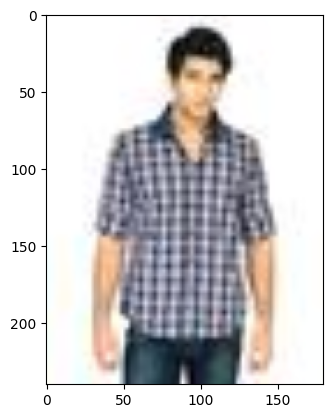

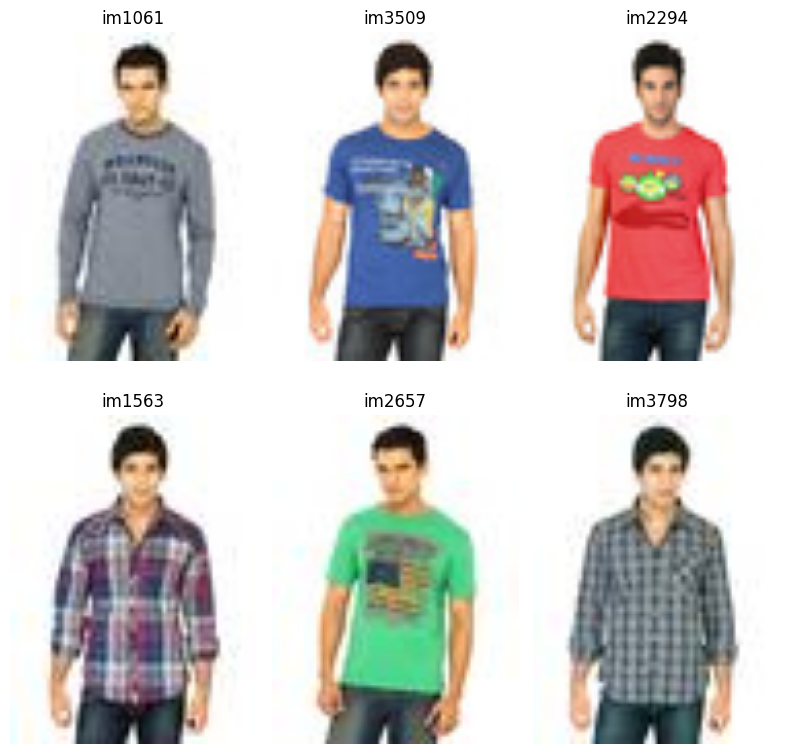

In [ ]:
# Idx Item to Recommender
idx_ref = 0

# Recommendations
idx_rec, idx_sim = get_recommender2(idx_ref, df, top_n = 6)

# Plot
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

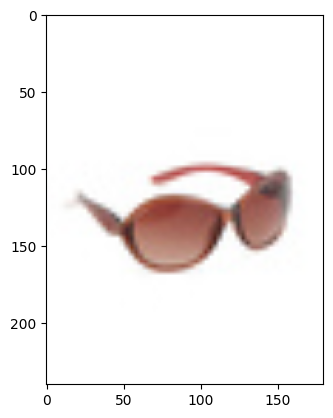

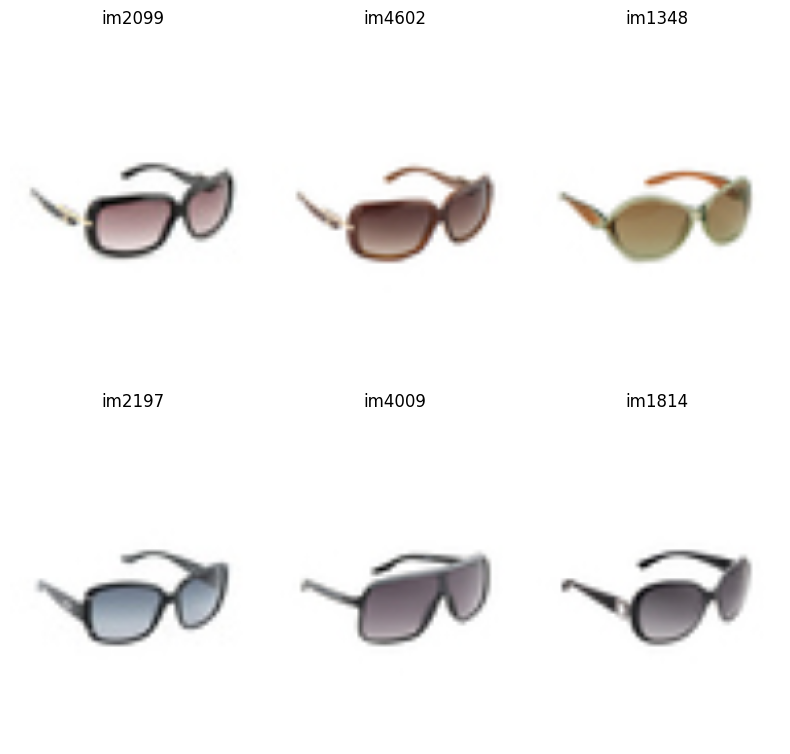

In [ ]:
# Idx Item to Recommender
idx_ref = 2993

# Recommendations
idx_rec, idx_sim = get_recommender2(idx_ref, df, top_n = 6)

# Plot
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

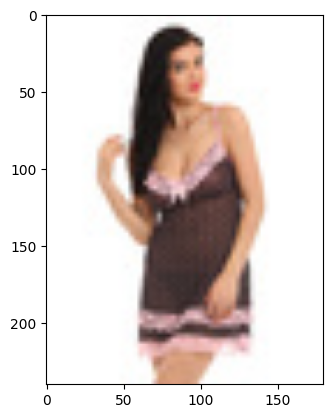

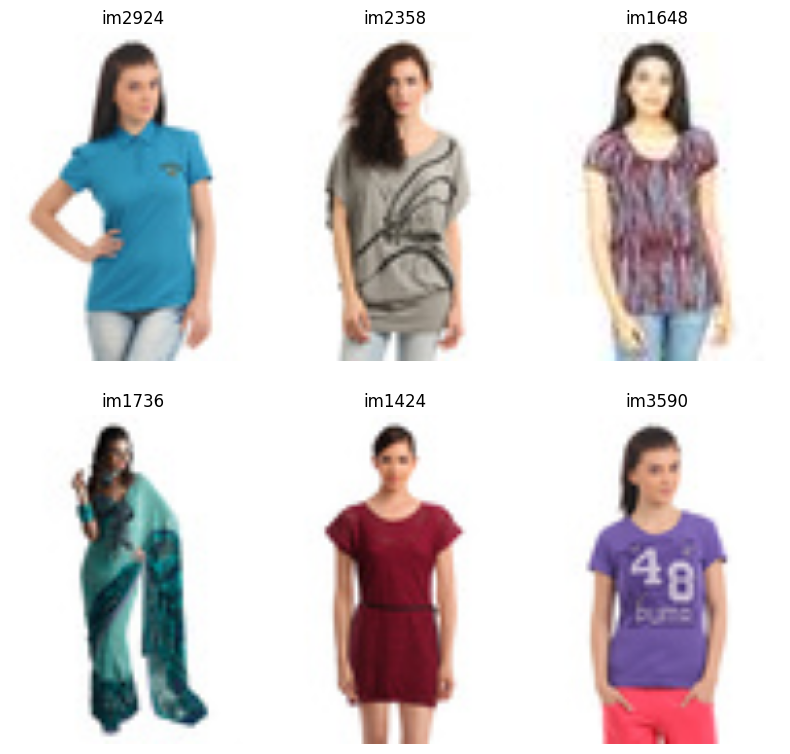

In [ ]:
idx_ref = 2989

# Recommendations
idx_rec, idx_sim = get_recommender2(idx_ref, df, top_n = 6)

# Plot
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

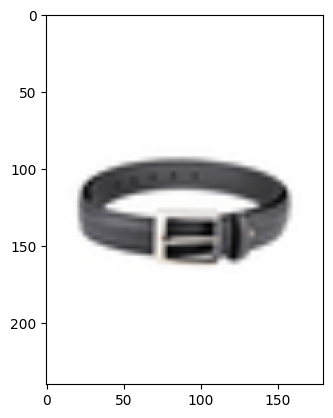

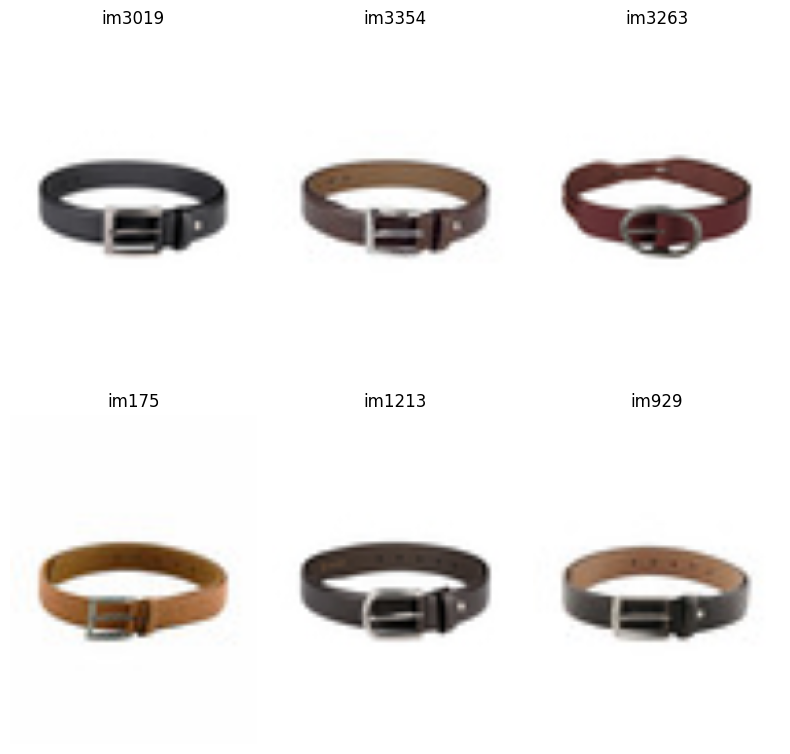

In [ ]:
idx_ref = 987

# Recommendations
idx_rec, idx_sim = get_recommender2(idx_ref, df, top_n = 6)

# Plot
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

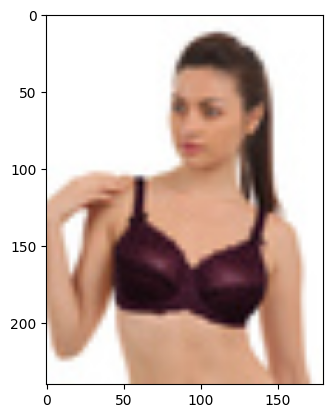

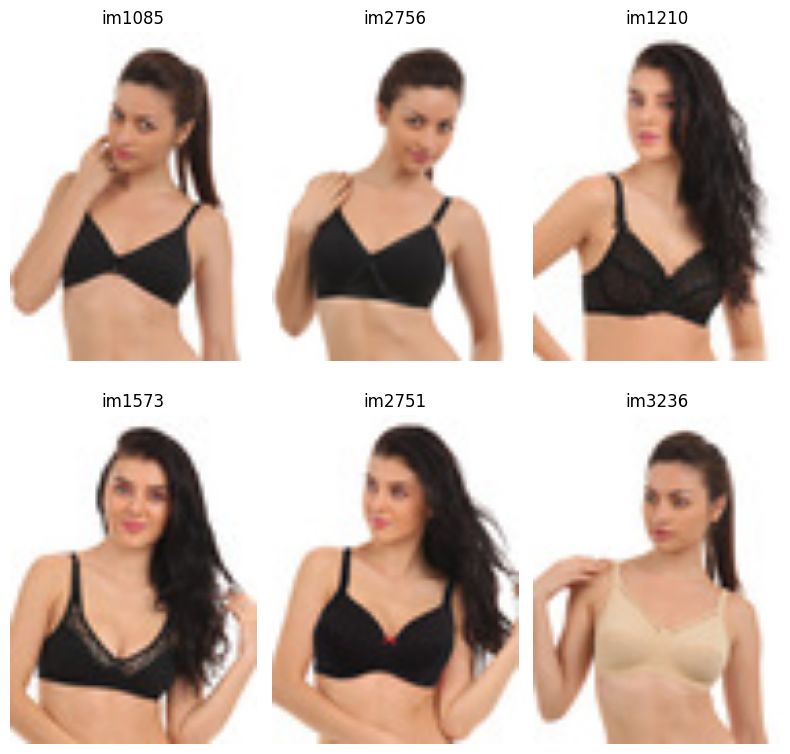

In [ ]:
idx_ref = 3524

# Recommendations
idx_rec, idx_sim = get_recommender2(idx_ref, df, top_n = 6)

# Plot
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

## Visualization Latent Space of Contents

Since our latent space is not two-dimensional, we will use TSNE to reduce dimensionality, so we can use some interesting visualizations that can be made at this point. One is to look at the neighborhoods of different classes in the latent 2D plane:

In [ ]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [ ]:
df.shape

(4984, 15)

In [ ]:
df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

   year   usage                             productDisplayName      image  \
0  2011  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg   
1  2012  Casual             Peter England Men Party Blue Jeans  39386.jpg   
2  2016  Casual                       Titan Women Silver Watch  59263.jpg   
3  2011  Casual  Manchester United Men Solid Black Track Pants  21379.jpg   
4  2012  Casual                          Puma Men Grey T-shirt  53759.jpg   

   tsne-2d-one-2  tsne-2d-two-2  tsne-2d-one-1  tsne-2d-two-1  
0       8.928440       2.311092       5.560327       1.433986  
1       1.837323       0.196410       2.149869      -0.306588  
2      -3.363235       6.822075      -1.861173      -8.957435  
3       1.755738       0.669831       2.183884      -0.626243  
4      10.110967       1.569244       4.683905       3.521647

In [ ]:
df_embs1.shape

(4984, 2048)

In [ ]:
df_embs2.shape

(4984, 128)

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results1 = tsne.fit_transform(df_embs1)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df['tsne-2d-one-1'] = tsne_results1[:,0]
df['tsne-2d-two-1'] = tsne_results1[:,1]

t-SNE done! Time elapsed: 25.161706924438477 seconds


In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results2 = tsne.fit_transform(df_embs2)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df['tsne-2d-one-2'] = tsne_results2[:,0]
df['tsne-2d-two-2'] = tsne_results2[:,1]

t-SNE done! Time elapsed: 17.172702312469482 seconds


<Axes: xlabel='tsne-2d-one-1', ylabel='tsne-2d-two-1'>

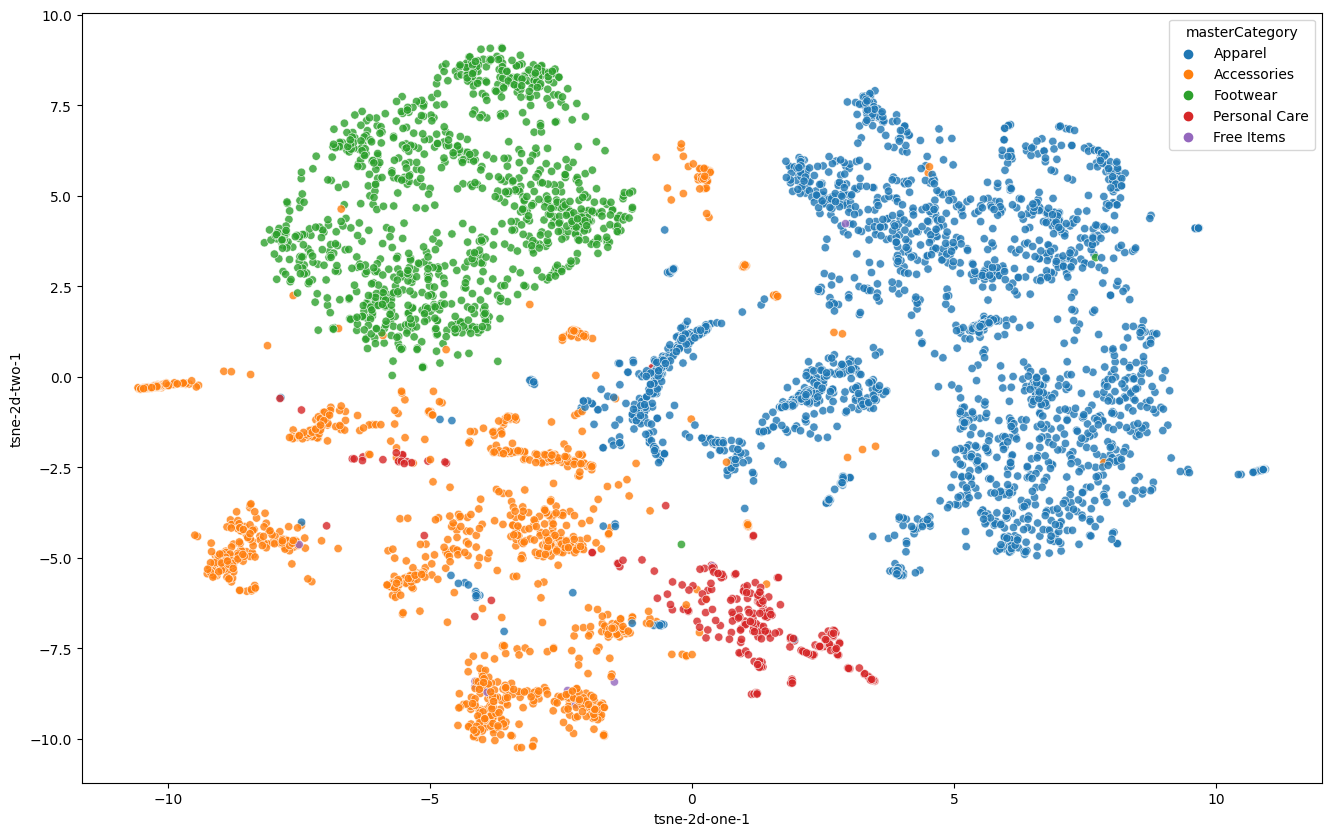

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one-1", y="tsne-2d-two-1",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

<Axes: xlabel='tsne-2d-one-2', ylabel='tsne-2d-two-2'>

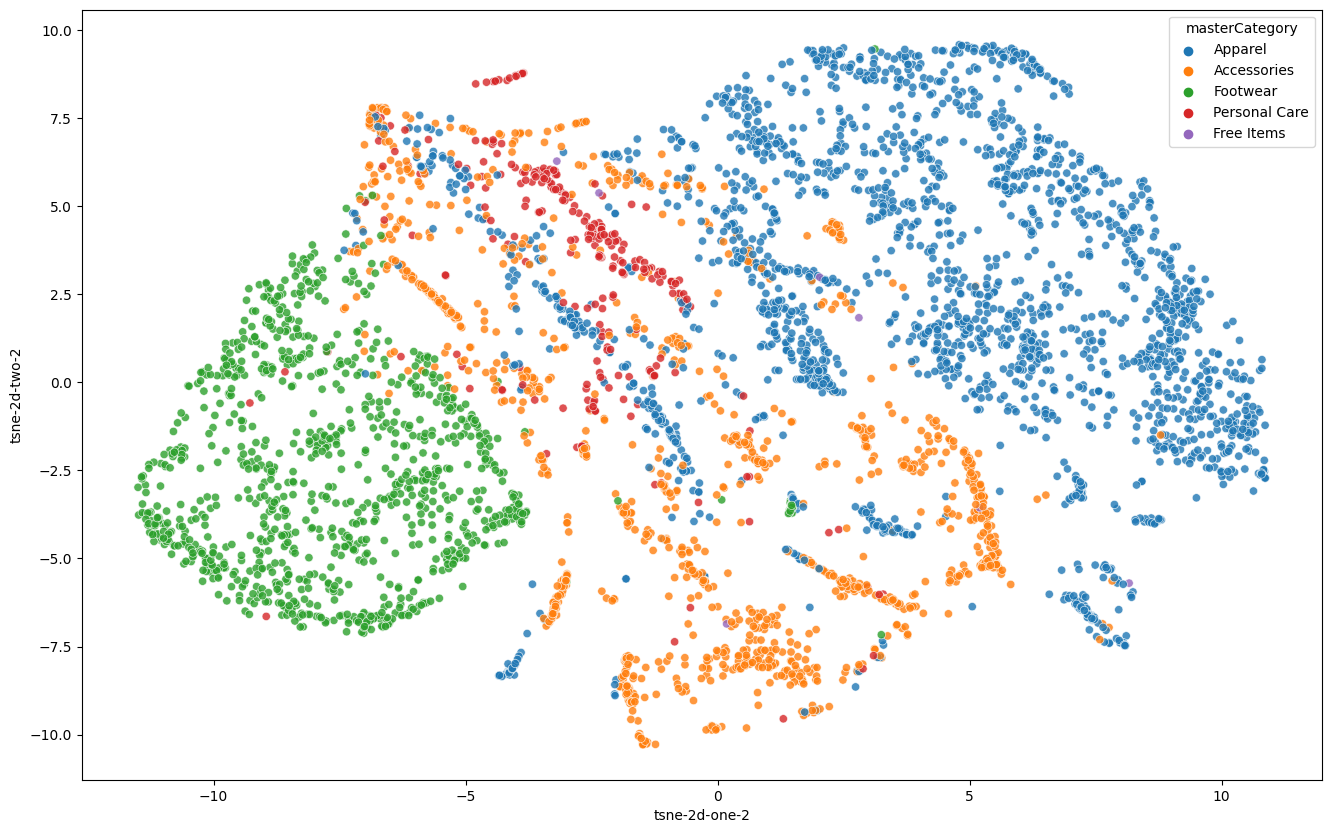

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one-2", y="tsne-2d-two-2",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

You can see different clusters generated by embeddings, which reinforces that features make sense. In this image above it is possible to observe the separation by Category, and in more detail by subcategory.

Of course there is actually a lot more information in embeddings, the visualization is for general understanding only

<Axes: xlabel='tsne-2d-one-1', ylabel='tsne-2d-two-1'>

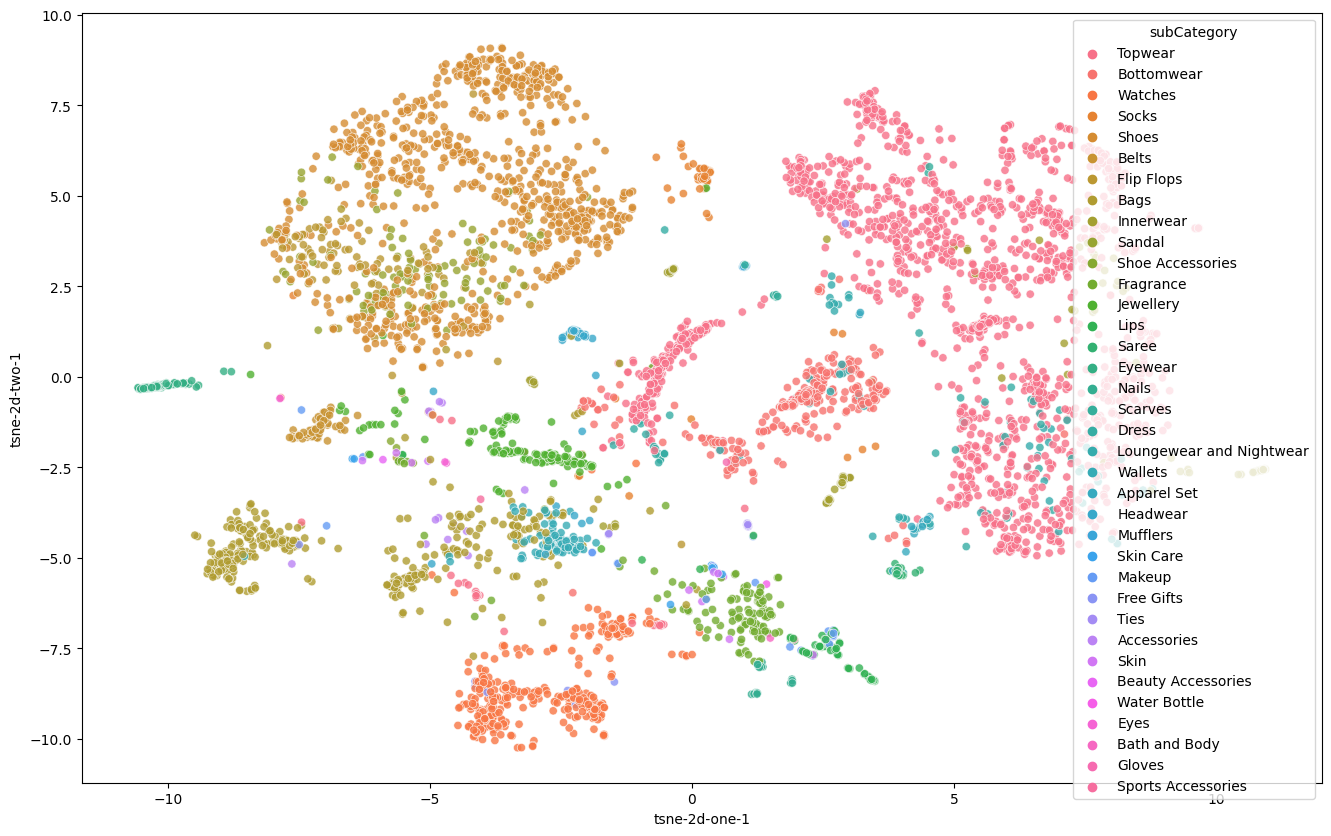

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one-1", y="tsne-2d-two-1",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

<Axes: xlabel='tsne-2d-one-2', ylabel='tsne-2d-two-2'>

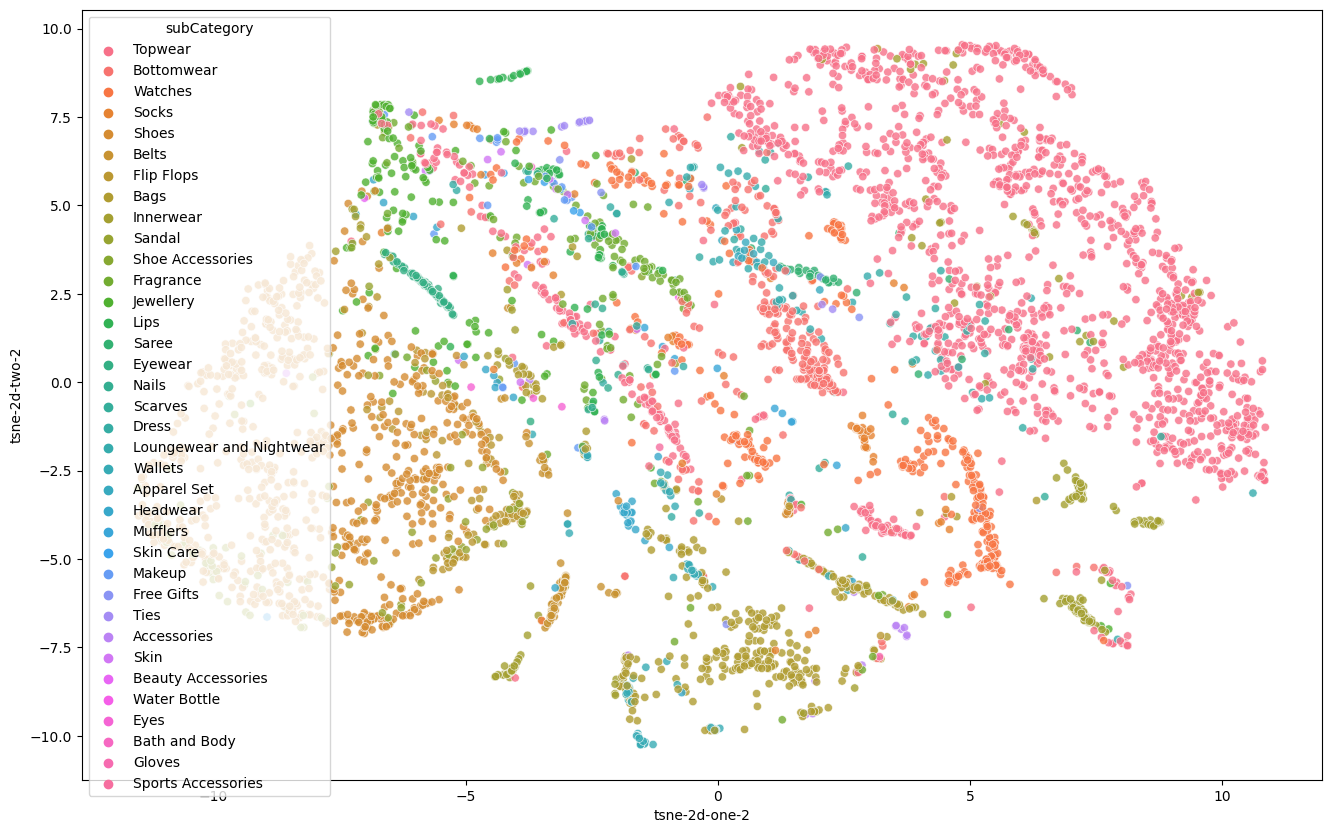

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one-2", y="tsne-2d-two-2",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

## Conclusion

Convolutional networks can be used to generate generic embeddings of any content. These embeddings can be used to identify similar items and in a recommendation process.

A big improvement would be to retrain some network layers in a dataset similar to the one that will be used. So the network learns better features for a specific problem.

In [ ]:
df_embs1.to_csv('embeddings1.csv')
df_embs2.to_csv('embeddings2.csv')
df.to_csv('metadados.csv')